In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

object
[180, 1620, 3060, 4500, 5940, 7380, 8820, 10260, 11700, 13140, 14580, 16020, 17460, 18900, 20340, 21780, 23220, 24660, 26100, 27540]
activity
0       383
372      40
483      25
687      22
756      21
       ... 
34        1
3009      1
41        1
40        1
2205      1
Name: count, Length: 142, dtype: int64
13


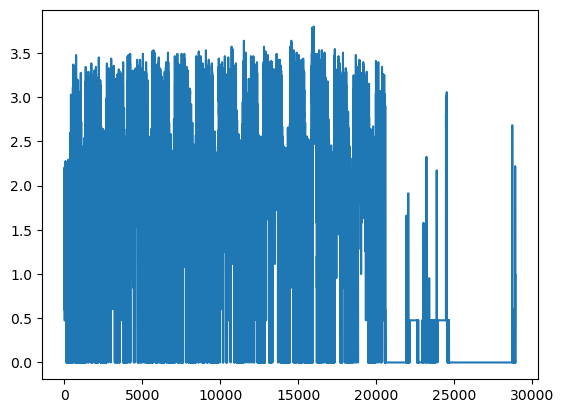

In [30]:
def log_skip_zeroes(x):
    if x == 0:
        return 0
    return math.log10(x)

dir_path = "data/all"
folders = ['condition', 'control']
scores = pd.read_csv("data/scores.csv", index_col='number')


data_path = os.path.join(dir_path, folders[1], "control_8.csv")
df = pd.read_csv(data_path)
print(df['timestamp'].dtype)
sr = df['timestamp'].map(lambda x: x.split()[1])
indexes_of_time = list(sr[sr=="12:00:00"].index)

num_days = scores.loc["control_8", "days"]
days = []
for i in range(num_days):
    interval = [indexes_of_time[i], indexes_of_time[i+1]]
    days.append(df.iloc[interval[0]:interval[1]])

print(indexes_of_time)
print(days[12]['activity'].value_counts())
print(len(days))

sr = df['activity']
sr = sr.map(lambda x : log_skip_zeroes(x))
ts = torch.from_numpy(sr.to_numpy()).float()
plt.plot(ts)

In [31]:
CONDITION_SIZE = 23
CONTROL_SIZE = 32
DIR_PATH = "data/all"
scores = pd.read_csv("data/scores.csv", index_col='number')

def load_data(dir_name: str, 
              dir_size: int, 
              class_type: str,  
              class_label: int,
              start_time: str,
              output_df: pd.DataFrame, 
              scores_df: pd.DataFrame):
    for i in range(1, dir_size + 1):
        
        # read CSV into truncated dataframe
        
        filename = f"{class_type}_{i}"
        datapath = os.path.join(dir_name, filename + ".csv")
        file_df = pd.read_csv(datapath)

        # find occurences of 

        sr = file_df['timestamp'].map(lambda x: x.split()[1])
        indexes_of_time = list(sr[sr==start_time].index)

        # split file_df into intervals of days

        num_days = scores_df.loc[filename, "days"]
        for j in range(num_days):
            interval = [indexes_of_time[j], indexes_of_time[j+1]]
            day_df = file_df.iloc[interval[0]:interval[1]]
            day_df = day_df['activity'].rename(f"{class_label}_{i}_{j}").reset_index(drop=True)
            
            # concatenate data column to output dataframe
            if(len(day_df) == 1440):
                output_df = pd.concat([output_df, day_df], axis=1)

    return output_df

actigraph_data = pd.DataFrame()
actigraph_data = load_data("data/all/control", 32, "control", 0, "12:00:00", actigraph_data, scores)
actigraph_data = load_data("data/all/condition", 23, "condition", 1, "12:00:00", actigraph_data, scores)

actigraph_data = actigraph_data.map(lambda x: log_skip_zeroes(x))
actigraph_data = actigraph_data.transpose()

actigraph_labels = actigraph_data.index.map(lambda x: int(x[0]))
X_train, X_test, y_train, y_test = train_test_split(actigraph_data, actigraph_labels, test_size=0.5, 
                                                    shuffle=True, random_state=42)

scaler = MinMaxScaler((0,1))
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

X_train, y_train

class ActigraphDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float().unsqueeze(dim=1)
        self.y = torch.tensor(y).float()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        # code for reshaping 1d tensor to 2d with padding
        '''
        new_shape = math.ceil(X.shape[0] / INPUT_SIZE)
        padding = new_shape * INPUT_SIZE - X.shape[0]
        p = nn.ZeroPad1d((0,padding))
        X = p(X)
        X = X.reshape((new_shape, INPUT_SIZE))
        '''
        return X, y

train_dataset = ActigraphDataset(X_train.to_numpy(), y_train)
test_dataset = ActigraphDataset(X_test.to_numpy(), y_test)

train_dataloader = DataLoader(train_dataset, 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, 32, shuffle=True)

X, y = next(iter(train_dataloader))
X.shape

torch.Size([32, 1, 1440])

In [32]:
#for i in range(len(train_dataset)):
#    num_nan = pd.Series(train_dataset[1][1].isnan()).value_counts()
#    print(num_nan)

X = train_dataset[300][0]
pd.Series(X.squeeze().isnan()).value_counts()

False    1440
Name: count, dtype: int64

In [6]:
na_series = actigraph_data.isna().sum(axis=1)
na_values = na_series[na_series > 0].index
actigraph_data.loc[na_values, 1375:]

,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439


In [7]:
control_6 = pd.read_csv("data/train/control_6.csv")

        # find occurences of 

sr = control_6['timestamp'].map(lambda x: x.split()[1])
indexes_of_time = list(sr[sr=='12:00:00'].index)

# split file_df into intervals of days

days = []

num_days = scores.loc["control_6", "days"]
for j in range(num_days):
    interval = [indexes_of_time[j], indexes_of_time[j+1]]
    day_df = control_6.iloc[interval[0]:interval[1]]
    day_df = day_df['activity'].rename(f"{0}_{i}_{j}").reset_index(drop=True)
    days.append(day_df)

days[12]

0       107
1       152
2        47
3       284
4        59
       ... 
1435      3
1436      3
1437      3
1438      3
1439      3
Name: 0_12_12, Length: 1440, dtype: int64

In [43]:
class ConvNN(nn.Module):
    def __init__(self, in_shape, output_dim, hidden_shape, flatten_factor):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(in_shape, hidden_shape, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(hidden_shape, hidden_shape, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv1d(hidden_shape, hidden_shape, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(hidden_shape, hidden_shape, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * flatten_factor, hidden_shape),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(hidden_shape, output_dim)
        )
    def forward(self, x):
        #print(x.shape)
        x = self.conv_block_1(x)
        #print(x.shape)
        #x = self.conv_block_2(x)
        x = self.linear(x)
        #print(x.shape)
        return x

IN_SHAPE = 1
OUT_SHAPE = 1
HIDDEN_SHAPE = 32
FLATTEN_FACTOR = 720
model_0 = ConvNN(IN_SHAPE, OUT_SHAPE, HIDDEN_SHAPE, FLATTEN_FACTOR).to(device)
model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[-0.2014,  0.0971, -0.2915]],
              
                      [[-0.2328, -0.0582,  0.2317]],
              
                      [[ 0.2686, -0.0995,  0.3462]],
              
                      [[ 0.3789, -0.2511,  0.5497]],
              
                      [[ 0.0990, -0.4364, -0.5645]],
              
                      [[-0.2448, -0.0765,  0.4478]],
              
                      [[ 0.0765,  0.4797,  0.1009]],
              
                      [[ 0.0560,  0.5131,  0.5102]],
              
                      [[ 0.1043,  0.2693, -0.2768]],
              
                      [[ 0.4129, -0.4008,  0.2442]],
              
                      [[ 0.3200, -0.0415, -0.1830]],
              
                      [[-0.0775,  0.4782,  0.5054]],
              
                      [[ 0.1575,  0.3093,  0.4614]],
              
                      [[ 0.4140,  0.2947,  0.4883]],
              
         

In [50]:
loss_fn = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.001)

epochs = 150
train_acc_graph = []
test_acc_graph = []
train_f1_graph = []
test_f1_graph = []

for epoch in range(epochs):
    train_acc, test_acc = 0, 0
    train_f1, test_f1 = 0, 0
    model_0.train()
    for _, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # forward pass
        out = model_0(X)
        preds = out.squeeze(dim=1).sigmoid().round()
        # calculate loss
        train_loss = loss_fn(out.squeeze(dim=1), y)
        # calculate accuracy
        acc = (preds==y).sum() / len(y)
        train_acc += acc
        train_f1 += f1_score(preds.cpu().detach(), 
                             y.cpu().detach())
        # backpropagation and updating weights
        train_loss.backward()
        optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        for _, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # forward pass
            out = model_0(X)
            preds = out.squeeze(dim=1).sigmoid().round()
            # calculate loss
            test_loss = loss_fn(out.squeeze(dim=1), y)
            # calculate accuracy
            acc = (preds==y).sum() / len(y)
            test_acc += acc
            test_f1 += f1_score(preds.cpu().detach(), 
                             y.cpu().detach())
    train_acc, test_acc = train_acc / len(train_dataloader), test_acc / len(test_dataloader)
    train_f1, test_f1 = train_f1 / len(train_dataloader), test_f1 / len(test_dataloader)
    train_acc_graph.append(train_acc.item())
    test_acc_graph.append(test_acc.item())
    train_f1_graph.append(train_f1)
    test_f1_graph.append(test_f1)
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.2f} | Test Loss: {test_loss:.4f} | Test F1: {test_f1:.2f}")

Epoch 0 | Train Loss: 0.5556 | Train F1: 0.72 | Test Loss: 0.5136 | Test F1: 0.66
Epoch 1 | Train Loss: 0.4227 | Train F1: 0.76 | Test Loss: 0.6065 | Test F1: 0.67
Epoch 2 | Train Loss: 0.6387 | Train F1: 0.74 | Test Loss: 0.5271 | Test F1: 0.62
Epoch 3 | Train Loss: 0.3623 | Train F1: 0.75 | Test Loss: 0.4875 | Test F1: 0.62
Epoch 4 | Train Loss: 0.4452 | Train F1: 0.75 | Test Loss: 0.5518 | Test F1: 0.63
Epoch 5 | Train Loss: 0.5794 | Train F1: 0.73 | Test Loss: 0.4491 | Test F1: 0.64
Epoch 6 | Train Loss: 0.5746 | Train F1: 0.78 | Test Loss: 0.5428 | Test F1: 0.66
Epoch 7 | Train Loss: 0.4724 | Train F1: 0.71 | Test Loss: 0.4578 | Test F1: 0.63
Epoch 8 | Train Loss: 0.4123 | Train F1: 0.74 | Test Loss: 0.5066 | Test F1: 0.65
Epoch 9 | Train Loss: 0.4841 | Train F1: 0.73 | Test Loss: 0.4468 | Test F1: 0.66
Epoch 10 | Train Loss: 0.5004 | Train F1: 0.78 | Test Loss: 0.5532 | Test F1: 0.66
Epoch 11 | Train Loss: 0.3960 | Train F1: 0.75 | Test Loss: 0.5160 | Test F1: 0.63
Epoch 12 | Tra

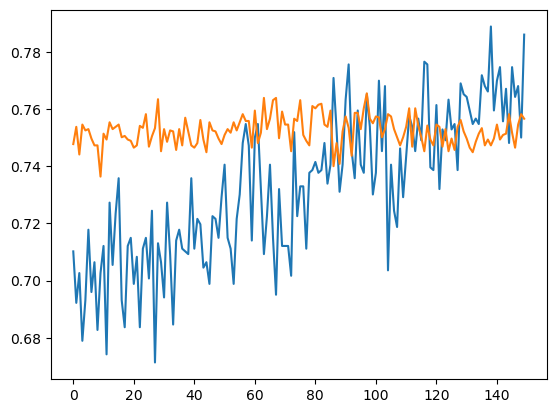

In [48]:
plt.plot(train_acc_graph)
plt.plot(test_acc_graph)

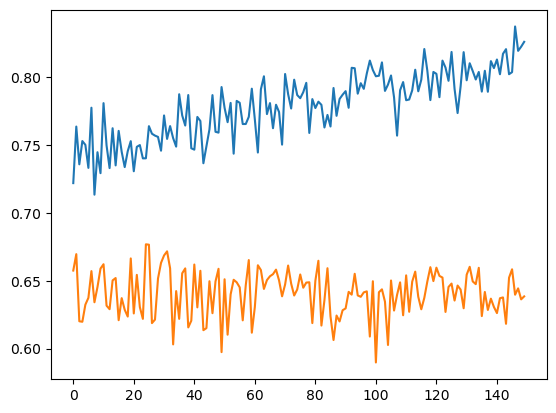

In [51]:
plt.plot(train_f1_graph)
plt.plot(test_f1_graph)